In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import itertools
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import random

### Quickdraw dataset

In [2]:
!pip3 install quickdraw

In [3]:
from quickdraw import QuickDrawData, QuickDrawDataGroup

In [4]:
seed = 111

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [5]:
num_img_per_class = 5000

qd = QuickDrawData(max_drawings=num_img_per_class)

class_list = ['apple', 
              'wine bottle', 
              'spoon', 
              'rainbow', 
              'panda', 
              'hospital', 
              'scissors', 
              'toothpaste', 
              'baseball', 
              'hourglass']

class_dict = {'apple' : 0, 
              'wine bottle' : 1, 
              'spoon' : 2, 
              'rainbow' : 3, 
              'panda': 4, 
              'hospital' : 5, 
              'scissors' : 6, 
              'toothpaste' : 7, 
              'baseball' : 8, 
              'hourglass' : 9}

In [6]:
qd.load_drawings(class_list)

downloading apple from https://storage.googleapis.com/quickdraw_dataset/full/binary/apple.bin
download complete
loading apple drawings
load complete
downloading wine bottle from https://storage.googleapis.com/quickdraw_dataset/full/binary/wine bottle.bin
download complete
loading wine bottle drawings
load complete
downloading spoon from https://storage.googleapis.com/quickdraw_dataset/full/binary/spoon.bin
download complete
loading spoon drawings
load complete
downloading rainbow from https://storage.googleapis.com/quickdraw_dataset/full/binary/rainbow.bin
download complete
loading rainbow drawings
load complete
downloading panda from https://storage.googleapis.com/quickdraw_dataset/full/binary/panda.bin
download complete
loading panda drawings
load complete
downloading hospital from https://storage.googleapis.com/quickdraw_dataset/full/binary/hospital.bin
download complete
loading hospital drawings
load complete
downloading scissors from https://storage.googleapis.com/quickdraw_datase

In [7]:
train_data = []
val_data = []

train_label = []
val_label = []

for class_name in class_list:
    qdgroup = QuickDrawDataGroup(class_name,
                                 max_drawings=num_img_per_class)
    
    for i, img in enumerate(qdgroup.drawings):
        if i<int(0.9*num_img_per_class):
            train_data.append(np.asarray(img.get_image()))
            train_label.append(class_dict[class_name])
        else:
            val_data.append(np.asarray(img.get_image()))
            val_label.append(class_dict[class_name])

loading apple drawings
load complete
loading wine bottle drawings
load complete
loading spoon drawings
load complete
loading rainbow drawings
load complete
loading panda drawings
load complete
loading hospital drawings
load complete
loading scissors drawings
load complete
loading toothpaste drawings
load complete
loading baseball drawings
load complete
loading hourglass drawings
load complete


In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227,227)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225]),
])

In [9]:
class QuickDrawDataset(Dataset):

    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        img = self.data[idx]
        
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Resnet Implementation
- ConvBlock
- ResBlock
- ResNet

### ConvBlock
- conv + bn + relu

In [10]:
class ConvBlock(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=True,
                 norm="bnorm",
                 relu=0.):
        super().__init__()

        layers = []
        layers += [nn.Conv2d(in_channels=in_channels,
                             out_channels=out_channels,
                             kernel_size=kernel_size,
                             stride=stride,
                             padding=padding,
                             bias=bias)]
        
        if norm is not None:
            layers += [nn.BatchNorm2d(num_features=out_channels)]

        if relu is not None:
            layers += [nn.ReLU()]

        self.convblk = nn.Sequential(*layers)

    def forward(self, x):

        return self.convblk(x)

### ResBlock
- ConvBlock + ConvBlock + skip connection

In [11]:
class ResBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=True,
                 norm="bnorm",
                 relu=0.,
                 shortcut=False):
        super().__init__()

        layers = []

        layers += [ConvBlock(in_channels=in_channels,
                             out_channels=out_channels,
                             kernel_size=kernel_size,
                             stride=stride,
                             padding=padding,
                             bias=bias,
                             norm=norm,
                             relu=relu)]

        layers += [ConvBlock(in_channels=out_channels,
                             out_channels=out_channels,
                             kernel_size=kernel_size,
                             stride=stride,
                             padding=padding,
                             bias=bias,
                             norm=norm,
                             relu=None)]

        self.resblk = nn.Sequential(*layers)
        
        self.shortcut = nn.Conv1d(in_channels,
                                  out_channels,
                                  (1,1),
                                  stride=1)
        
    def forward(self, x, shortcut=False):
        if shortcut:
            return self.shortcut(x) + self.resblk(x)
        else:
            return x + self.resblk(x)

### ResNet

In [12]:
class ResNet(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 nker=64,
                 norm="bnorm",
                 nblk=[3,4,6,3]):
        super(ResNet, self).__init__()

        self.enc = ConvBlock(in_channels, nker, kernel_size=7, stride=2, padding=1, bias=True, norm=None, relu=0.)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        res_1 = ResBlock(nker, nker, kernel_size=3, stride=1, padding=1, bias=True, norm=norm, relu=0.)
        self.res_1 = nn.Sequential(*[res_1 for _ in range(nblk[0])])

        self.res_2_up = ResBlock(nker, nker*2, kernel_size=3, stride=1, padding=1, bias=True, norm=norm, relu=0.0)
        res_2 = ResBlock(nker*2, nker*2, kernel_size=3, stride=1, padding=1, bias=True, norm=norm, relu=0.0)
        self.res_2 = nn.Sequential(*[res_2 for _ in range(nblk[1]-1)])

        self.res_3_up = ResBlock(nker*2, nker*2*2, kernel_size=3, stride=1, padding=1, bias=True, norm=norm, relu=0.0)
        res_3 = ResBlock(nker*2*2, nker*2*2, kernel_size=3, stride=1, padding=1, bias=True, norm=norm, relu=0.0)
        self.res_3 = nn.Sequential(*[res_3 for _ in range(nblk[2]-1)])

        self.res_4_up = ResBlock(nker*2*2, nker*2*2*2, kernel_size=3, stride=1, padding=1, bias=True, norm=norm, relu=0.0)
        res_4 = ResBlock(nker*2*2*2, nker*2*2*2, kernel_size=3, stride=1, padding=1, bias=True, norm=norm, relu=0.0)
        self.res_4 = nn.Sequential(*[res_4 for _ in range(nblk[3]-1)])

        self.avg_pooling = nn.AdaptiveAvgPool2d(output_size=1) # width, height to 1
        self.fc = nn.Linear(nker*2*2*2, 10)  

    def forward(self, x):

        x = self.enc(x)
        x = self.max_pool(x)

        x = self.res_1(x)
        x = self.max_pool(x)

        x = self.res_2_up(x, shortcut=True)
        x = self.res_2(x)
        x = self.max_pool(x)

        x = self.res_3_up(x, shortcut=True)
        x = self.res_3(x)
        x = self.max_pool(x)

        x = self.res_4_up(x, shortcut=True)
        x = self.res_4(x)
        x = self.avg_pooling(x)

        x = x.view(x.shape[0], -1)
        out = self.fc(x)
        
        return out

In [13]:
model_test = ResNet(3, 10) # in_channels, out_channels

x = torch.randn((4, 3, 227, 227)) # batch_size, channels, width, height

out = model_test(x)

print(out.shape) # batch_size, classes

torch.Size([4, 10])


# Training from scratch

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model_scratch = ResNet(3, 10)
model_scratch.to(device)

cuda


ResNet(
  (enc): ConvBlock(
    (convblk): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
  )
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (res_1): Sequential(
    (0): ResBlock(
      (resblk): Sequential(
        (0): ConvBlock(
          (convblk): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (1): ConvBlock(
          (convblk): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
      )
      (shortcut): Conv1d(64, 64, kernel_size=(1, 1), stride=(1,))
    )
    (1): ResBlock(
      (resblk): Sequential(
        (0): 

In [15]:
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_scratch.parameters(), lr=1e-4)

In [16]:
log_dir = './log'

In [28]:
qd_train_dataset = QuickDrawDataset(train_data, train_label, transform)
qd_val_dataset = QuickDrawDataset(val_data, val_label, transform)

BATCH_SIZE = 64
qd_train_dataloader = DataLoader(qd_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
qd_val_dataloader = DataLoader(qd_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [29]:
class AverageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

In [30]:
os.makedirs(log_dir, exist_ok=True)

with open(os.path.join(log_dir, 'scratch_train_log.csv'), 'w') as log:

    model_scratch.train()

    for iter, (img, label) in enumerate(qd_train_dataloader):

        optimizer.zero_grad()

        img, label = img.float().to(device), label.long().to(device)

        pred_logit = model_scratch(img)

        loss = criterion(pred_logit, label)

        loss.backward()
        optimizer.step()

        pred_label = torch.argmax(pred_logit, 1)
        acc = (pred_label==label).sum().item() / len(img)

        train_loss = loss.item()
        train_acc = acc

        if (iter%20==0) or (iter==len(qd_train_dataloader)-1):

            model_scratch.eval()

            valid_loss, valid_acc = AverageMeter(), AverageMeter()

            for img, label in qd_val_dataloader:

                img, label = img.float().to(device), label.long().to(device)

                with torch.no_grad():
                    pred_logit = model_scratch(img)

                loss = criterion(pred_logit, label)

                pred_label = torch.argmax(pred_logit, 1)
                acc = (pred_label==label).sum().item() / len(img)

                valid_loss.update(loss.item(), len(img))
                valid_acc.update(acc, len(img))

            valid_loss = valid_loss.avg
            valid_acc = valid_acc.avg

            print("Iter [%3d/%3d] | Train Loss %.4f | Train Acc %.4f | Valid Loss %.4f | Valid Acc %.4f" %
            (iter, len(qd_train_dataloader), train_loss, train_acc, valid_loss, valid_acc))
      
            log.write('%d,%.4f,%.4f,%.4f,%.4f\n'%(iter, train_loss, train_acc, valid_loss, valid_acc))

Iter [  0/704] | Train Loss 2.0374 | Train Acc 0.5625 | Valid Loss 0.8762 | Valid Acc 0.7150
Iter [ 20/704] | Train Loss 0.6341 | Train Acc 0.7969 | Valid Loss 0.5582 | Valid Acc 0.8310
Iter [ 40/704] | Train Loss 0.5106 | Train Acc 0.8750 | Valid Loss 0.5192 | Valid Acc 0.8556
Iter [ 60/704] | Train Loss 0.3447 | Train Acc 0.7969 | Valid Loss 0.4983 | Valid Acc 0.8514
Iter [ 80/704] | Train Loss 0.6726 | Train Acc 0.7969 | Valid Loss 0.4572 | Valid Acc 0.8694
Iter [100/704] | Train Loss 0.5989 | Train Acc 0.7812 | Valid Loss 0.4997 | Valid Acc 0.8592
Iter [120/704] | Train Loss 0.6109 | Train Acc 0.8281 | Valid Loss 0.4834 | Valid Acc 0.8556
Iter [140/704] | Train Loss 0.4338 | Train Acc 0.8594 | Valid Loss 0.4201 | Valid Acc 0.8742
Iter [160/704] | Train Loss 0.2323 | Train Acc 0.9531 | Valid Loss 0.4160 | Valid Acc 0.8820
Iter [180/704] | Train Loss 0.3969 | Train Acc 0.8281 | Valid Loss 0.5031 | Valid Acc 0.8458
Iter [200/704] | Train Loss 0.4108 | Train Acc 0.8594 | Valid Loss 0.3

# torchvision pretrained freeze

In [31]:
from torchvision.models import resnet34

pretrained = True

model_finetune = resnet34(pretrained)
model_finetune

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Freezing convolution layers
for param in model_finetune.parameters():
    param.requires_grad = False

model_finetune.fc = nn.Linear(512, 10, bias=True)

model_finetune.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
from torch.optim import Adam 

criterion = nn.CrossEntropyLoss()
optimizer_ft = Adam(model_finetune.parameters(), lr=1e-4)

In [34]:
os.makedirs(log_dir, exist_ok=True)

with open(os.path.join(log_dir, 'fine_tuned_train_log.csv'), 'w') as log:

    model_finetune.train()

    for iter, (img, label) in enumerate(qd_train_dataloader):

        img, label = img.float().to(device), label.long().to(device)

        optimizer_ft.zero_grad()

        pred_logit = model_finetune(img)

        loss = criterion(pred_logit, label)

        loss.backward()
        optimizer_ft.step()

        pred_label = torch.argmax(pred_logit, 1)
        acc = (pred_label==label).sum().item() / len(img)

        train_loss = loss.item()
        train_acc = acc

        if (iter%20==0) or (iter==len(qd_train_dataloader)-1):
            
            model_finetune.eval()
            
            valid_loss, valid_acc = AverageMeter(), AverageMeter()

            for img, label in qd_val_dataloader:

                img, label = img.float().to(device), label.long().to(device)

                with torch.no_grad():
                    pred_logit = model_finetune(img)

                loss = criterion(pred_logit, label)

                pred_label = torch.argmax(pred_logit, 1)
                acc = (pred_label==label).sum().item() / len(img)

                valid_loss.update(loss.item(), len(img))
                valid_acc.update(acc, len(img))

            valid_loss = valid_loss.avg
            valid_acc = valid_acc.avg

            print("Iter [%3d/%3d] | Train Loss %.4f | Train Acc %.4f | Valid Loss %.4f | Valid Acc %.4f" %
            (iter, len(qd_train_dataloader), train_loss, train_acc, valid_loss, valid_acc))
      
            log.write('%d,%.4f,%.4f,%.4f,%.4f\n'%(iter, train_loss, train_acc, valid_loss, valid_acc))

Iter [  0/704] | Train Loss 2.6159 | Train Acc 0.0469 | Valid Loss 2.6141 | Valid Acc 0.1028
Iter [ 20/704] | Train Loss 2.5376 | Train Acc 0.0938 | Valid Loss 2.4066 | Valid Acc 0.1332
Iter [ 40/704] | Train Loss 2.1881 | Train Acc 0.3438 | Valid Loss 2.2709 | Valid Acc 0.2058
Iter [ 60/704] | Train Loss 2.1887 | Train Acc 0.2188 | Valid Loss 2.1774 | Valid Acc 0.2638
Iter [ 80/704] | Train Loss 2.0515 | Train Acc 0.3750 | Valid Loss 2.0978 | Valid Acc 0.3244
Iter [100/704] | Train Loss 1.9406 | Train Acc 0.4062 | Valid Loss 2.0217 | Valid Acc 0.3934
Iter [120/704] | Train Loss 1.9134 | Train Acc 0.5312 | Valid Loss 1.9469 | Valid Acc 0.4876
Iter [140/704] | Train Loss 1.8941 | Train Acc 0.5000 | Valid Loss 1.8791 | Valid Acc 0.5246
Iter [160/704] | Train Loss 1.7814 | Train Acc 0.5938 | Valid Loss 1.8146 | Valid Acc 0.5676
Iter [180/704] | Train Loss 1.8120 | Train Acc 0.5781 | Valid Loss 1.7533 | Valid Acc 0.6020
Iter [200/704] | Train Loss 1.7080 | Train Acc 0.6094 | Valid Loss 1.6

# Result visualization

In [35]:
scratch_train_log = pd.read_csv(os.path.join(log_dir, 'scratch_train_log.csv'), index_col=0, header=None)
fine_tuned_train_log = pd.read_csv(os.path.join(log_dir, 'fine_tuned_train_log.csv'), index_col=0, header=None)

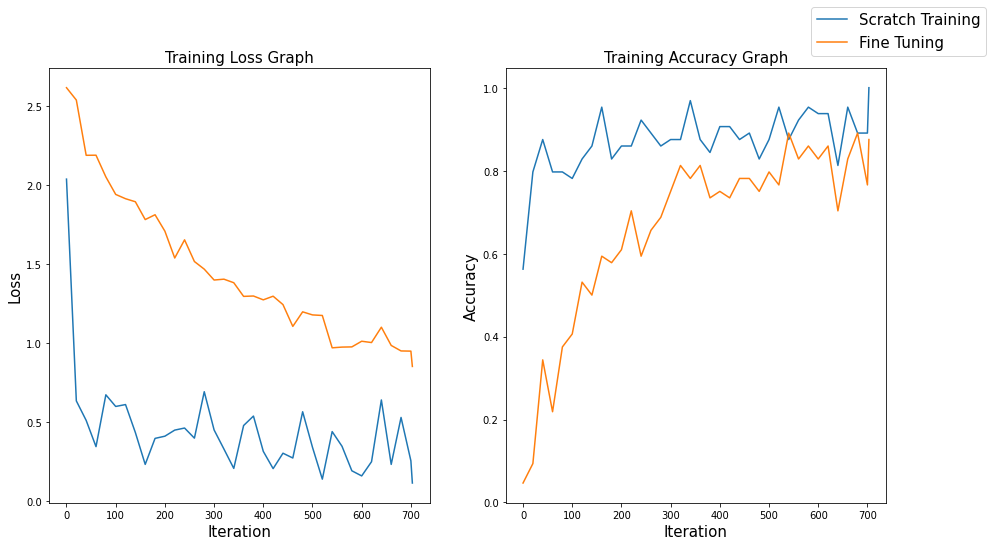

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1.plot(scratch_train_log.iloc[:,0], label='Scratch Training')
ax1.plot(fine_tuned_train_log.iloc[:,0], label='Fine Tuning')
ax1.set_title('Training Loss Graph', fontsize=15)
ax1.set_xlabel('Iteration', fontsize=15)
ax1.set_ylabel('Loss', fontsize=15)

fig.legend(fontsize=15)

ax2.plot(scratch_train_log.iloc[:,1], label='Scratch Training')
ax2.plot(fine_tuned_train_log.iloc[:,1], label='Fine Tuning')
ax2.set_title('Training Accuracy Graph', fontsize=15)
ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=15)

plt.show()

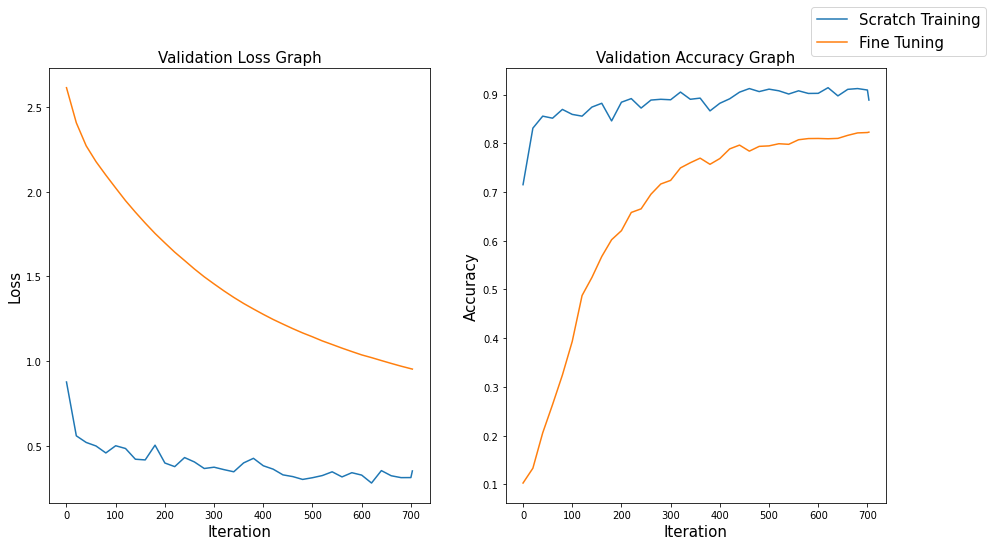

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1.plot(scratch_train_log.iloc[:,2], label='Scratch Training')
ax1.plot(fine_tuned_train_log.iloc[:,2], label='Fine Tuning')
ax1.set_title('Validation Loss Graph', fontsize=15)
ax1.set_xlabel('Iteration', fontsize=15)
ax1.set_ylabel('Loss', fontsize=15)

fig.legend(fontsize=15)

ax2.plot(scratch_train_log.iloc[:,3], label='Scratch Training')
ax2.plot(fine_tuned_train_log.iloc[:,3], label='Fine Tuning')
ax2.set_title('Validation Accuracy Graph', fontsize=15)
ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=15)

plt.show()